**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from text_classification import set_gpu_memory, lr_schedule, ngram_vectorize, sequence_vectorize
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import DictToObject, TextClassificationHelper
from text_classification import SimpleTextDataset, SequenceTextDataset

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'set_gpu_memory'

In [ ]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
set_gpu_memory(1024)
model_results={}

set max gpu memory to 1024


初始化参数。

In [4]:
params = {
    'dataset_name': 'imdb',
    'sample_perecent': 1,
    'classes': ['Negative', 'Positive'],
    'validation_percent': 0.0,     
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':20},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.2, 'embedding_dim':200, 'epochs':10},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
    }
}

params = DictToObject(params)

### 下载数据

开始下载数据。

In [5]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [6]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [7]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [8]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [9]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

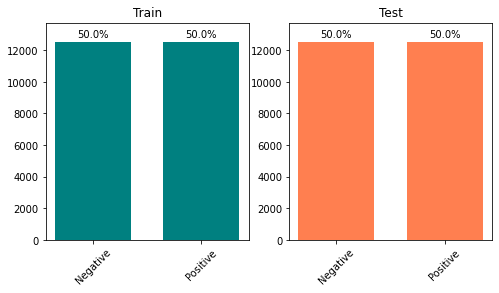

In [10]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

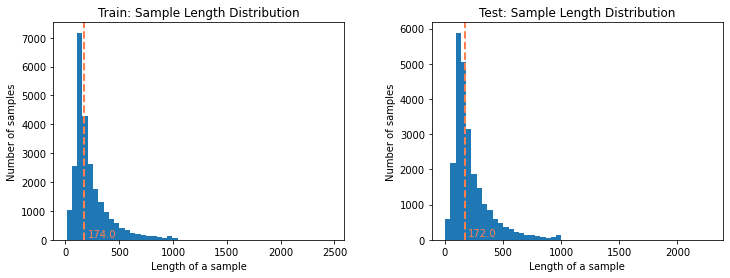

train：mean=233.79 variance=30181.96
test：mean=228.53 variance=28520.56


In [11]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

![image-20210101163434402](images/image-20210101163434402.png)

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [12]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3091,11744,4697,2321,1251,752,434,289,421,25000
train,2926,11654,4665,2385,1340,786,464,307,473,25000
合计,6017,23398,9362,4706,2591,1538,898,596,894,50000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
train,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
合计,6017.0,23398.0,9362.0,4706.0,2591.0,1538.0,898.0,596.0,894.0,50000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [13]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 14.229826210223425
critical_value = 15.50731305586545
p_value = 0.07596828551367163


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

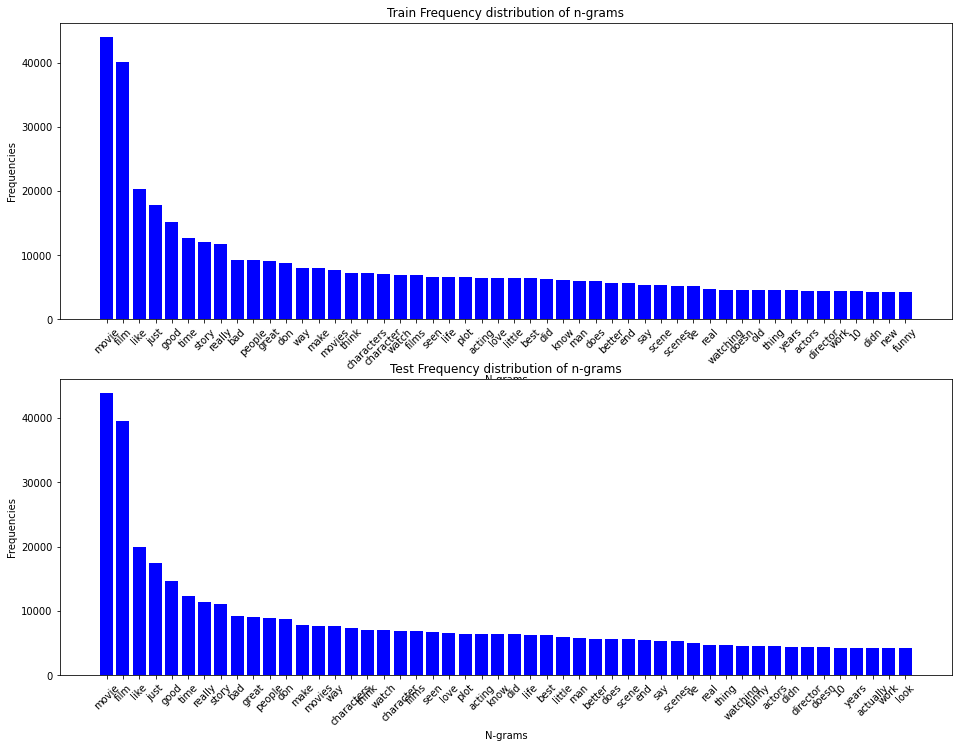

In [14]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [15]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 23078


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [16]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [17]:
train_ngram, test_ngram, token_vectorizer = ngram_vectorize(train_texts, train_labels, test_texts, 
                                                            top_k=params.max_features)

print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


(25000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(25000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 112)	0.023057178
  (0, 216)	0.02561007
  (0, 222)	0.015668478
  (0, 250)	0.029491138
  (0, 345)	0.04319149
  (0, 371)	0.015204369
  (0, 380)	0.033524606
  (0, 528)	0.023064084
  (0, 590)	0.019929541
  (0, 769)	0.06380487
  (0, 879)	0.031043448


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [18]:
ngram_data = SimpleTextDataset(params, train_ngram, train_labels, test_ngram, test_labels, train_texts, test_texts)

create train, validation and test dataset


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [19]:
train_seq, test_seq, tokenizer_seq = sequence_vectorize(train_texts, test_texts, 
                                                        top_k=params.max_features,
                                                        max_sequence_length =params.sequence_length
                                                       )

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[0][0:500])

(25000, 500) <class 'numpy.ndarray'> int32
(25000, 500) <class 'numpy.ndarray'> int32
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

![image-20210102105418015](images/image-20210102105418015.png)

创建sequence数据集。

In [20]:
sequence_data = SequenceTextDataset(params, train_seq, train_labels, test_seq, test_labels, 
                                    train_texts, test_texts, tokenizer_seq)

create train, validation and test dataset


#### TextVectorization

下面直接从原始的文件读入数据，删除无用的目录。

In [21]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir): shutil.rmtree(remove_dir)
print(os.listdir(train_dir))

['neg', 'pos', 'unsup', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


![image-20210102102355896](images/image-20210102102355896.png)

把数据下载进dataset。

In [22]:
batch_size = params.batch_size
validation_split = params.validation_percent
seed = 42

if validation_split>0:
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='training', 
        seed=seed)

    print('-'*100)
    raw_val_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='validation', 
        seed=seed)    
    
else:
    print('-'*100)
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size)
    raw_val_seq_ds = None


print('-'*100)
raw_test_seq_ds = preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_seq_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_seq_ds.class_names[0])
print("Label 1 corresponds to", raw_train_seq_ds.class_names[1])       

----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
-------------------------------------------------- 0 --------------------------------------------------
b'I would not consider myself as one of Leonard Cohen\'s greatest fans. He does however feature as an important poet / musician in my literary / musical heritage. By far the most valuable element in this documentary is to hear Leonard\'s reflections on his own life and career. Warming and humble. <br /><br />Unfortunately the most of the musicians featured in the concert didn\'t converse the nuances of Leonard\'s musical / literary manner. Nick Cave, Jarvis Cocker & Beth Orton were the exceptions, even though Leonard highly values Rufus Wainrights interpretations of his songs.<br /><br />What particular

![image-20210102102702043](images/image-20210102102702043.png)

然后把进行Vectorization。

In [23]:
max_features = params.max_features
sequence_length = params.sequence_length

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_seq_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  is
1287 --->  lovely
 313 --->  idea
Vocabulary size: 20000


![image-20210102105650161](images/image-20210102105650161.png)

然后生成具体的train，validation，test数据集。

In [24]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_seq_ds = raw_train_seq_ds.map(vectorize_text)
if raw_val_seq_ds is not None:
    val_seq_ds = raw_val_seq_ds.map(vectorize_text)
else:
    val_seq_ds = None
test_seq_ds = raw_test_seq_ds.map(vectorize_text)

# cache data to improve the performance
train_seq_ds = train_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
if val_seq_ds is not None: 
    val_seq_ds = val_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_seq_ds = test_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 查看数据
vector_batch, label_batch = next(iter(train_seq_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(params.classes[first_label]))
print('-'*40, 'Vector', '-'*40)
print(first_vector.numpy())
print('-'*40, 'orginal review', '-'*40)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

Label：Positive
---------------------------------------- Vector ----------------------------------------
[    1    90     9   171   153   973     4     1   218   376     5    24
   198 17196    16     4  9893  5637     3   105  4089   372    71  1437
     3  1437    48     4  1066     2   223     7  2555     3    77     2
  1183     2  1314     2   918 16045   389     3   472  8120     3 14602
   276     1  1081     6  2739    61  1025   432     8  3253     4   373
   567     6   103     3    28     7  5185  6042   231    49  1262    23
    37  1242     3    37   373    73    11     7    28     3    44    22
   494     1   924    95   482   115    11   254    14     8    31  1262
     9     7    42     4  8772  2065     3    22    25     6    26     8
     2  1272    15     9     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

![image-20210102141537073](images/image-20210102141537073.png)

![image-20210102141609143](images/image-20210102141609143.png)

##  模型

### MLP

In [25]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.data.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=ngram_data)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)

2021-01-05 02:12:39,180: INFO: start training


model_params.mlp.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
782/782 [==============================] - 5s 7ms/step - loss: 0.3637 - accuracy: 0.8442 - val_loss: 0.2495 - val_accuracy: 0.8993
Epoch 2/20
782/782 [==============================] - 5s 6ms/step - loss: 0.2314 - accuracy: 0.9056 - val_loss: 0.2406 - val_accuracy: 0.9017
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 0.2016 - accuracy: 0.9171 - val_loss: 0.2409 - val_accuracy: 0.9011
Epoch 4/20
782/782 [==============================] - 5s 6ms/step - loss: 0.1867 - accuracy: 0.9247 - val_loss: 0.2480 - val_accuracy: 0.8982
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.1713 - accuracy: 0.9295 - val_loss: 0.2517 - val_accuracy: 0.8986
Epoch 6/20
782/

2021-01-05 02:14:22,401: INFO: finish training [elapsed time: 103.22 seconds]


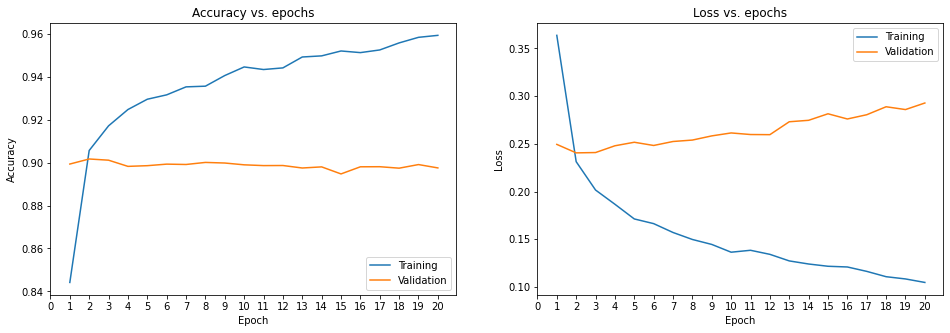

In [26]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 2s 3ms/step - loss: 0.2406 - accuracy: 0.9017
Test loss:0.2406, Test Accuracy:90.17%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 2s 2ms/step


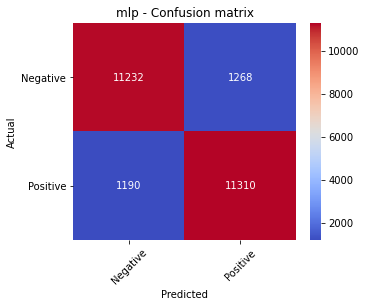

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.122995,0.9585,0.240577,0.9017,5120770,103.0


In [27]:
helper.model_summary(model, history=history)

### LSTM

In [31]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=20000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm/checkpoint
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 4,321,402
Trainable params: 4,321,402
Non-

2021-01-05 02:14:31,251: INFO: start training


model_params.rnn_lstm.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
781/781 [==============================] - 529s 677ms/step - loss: 0.4781 - accuracy: 0.7713 - val_loss: 0.3625 - val_accuracy: 0.8491
Epoch 2/5
781/781 [==============================] - 538s 689ms/step - loss: 0.3138 - accuracy: 0.8715 - val_loss: 0.3895 - val_accuracy: 0.8428
Epoch 3/5
781/781 [==============================] - 505s 646ms/step - loss: 0.1770 - accuracy: 0.9352 - val_loss: 0.3719 - val_accuracy: 0.8552
Epoch 4/5
781/781 [==============================] - 505s 647ms/step - loss: 0.1464 - accuracy: 0.9451 - val_loss: 0.4362 - val_accuracy: 0.8434
Epoch 5/5
781/781 [==============================] - 506s 648ms/step - loss: 0.0842 - accuracy: 0.9711 - val_loss: 0.8419 - val_accuracy

2021-01-05 02:57:40,862: INFO: finish training [elapsed time: 2589.61 seconds]


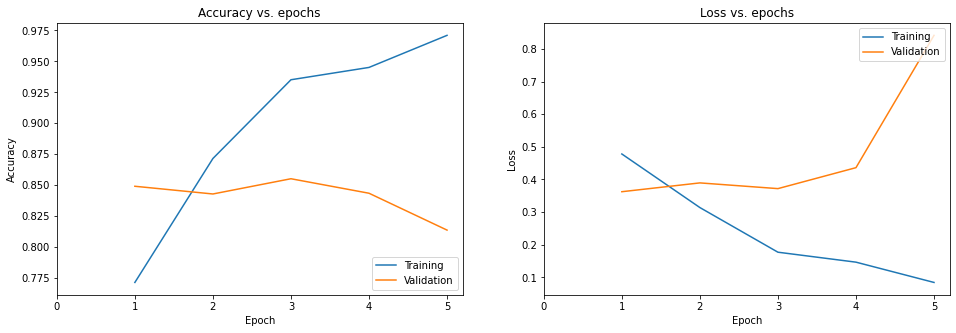

In [32]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 95s 122ms/step - loss: 0.3719 - accuracy: 0.8552
Test loss:0.3719, Test Accuracy:85.52%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 95s 121ms/step


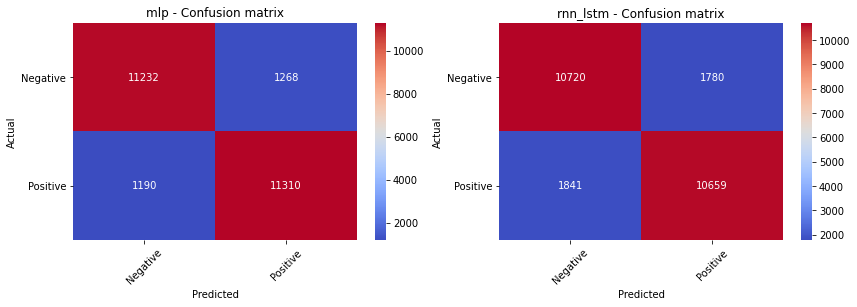

---------------------------------------- error analysis ----------------------------------------
782/782 [==============================] - 94s 120ms/step
........................................ Positive ........................................
The SF premise isn't unique (although it pretty much was back then), but the focus is a completely different one than in other artificial reality films. Especially during the first part it is an elaborate crime picture, that uses the SF premise to tell an unusual crime story in which the forced detective tries to solve a mystery with the obstacle of vanishing characters and unhelpful witnesses who don't have to lie to be unhelpful. Instead of an unreliable narrator we have an unreliable world.<br /><br />In part two we follow the main character's struggle for sanity and it turns more into a psychological examination of a character in an extreme situation. He knows his very existence is nothing more than electrical impulses, how does he deal wit

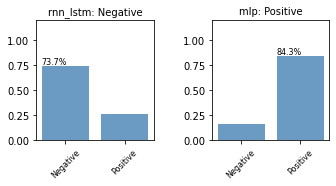

........................................ Negative ........................................
The film was disappointing. I saw it on Broadway with Bernadette Peters and she was outstanding. Maybe as she, herself graps on to the end of her musical career, her condtion of desperatation lands her in role that she flaunts, re-invents and triumps as her own. Bette's singing is always belted, always flat and lacking to show her ability as an actress. To be entertaining, this performance was dying for a stronger lead and a stronger cast, so that the others would be memorable in Bette's absence. Another criticism: she smiles directly into the camera every time she start singing! I know it is musical theater, but please leave some grace sociale-- Middler cannot perform like Liza or Streisand might in a retrospective tour - out of character and out of context.


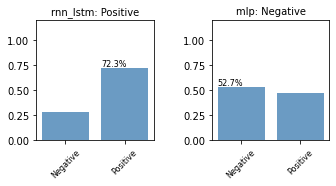

........................................ Negative ........................................
There is no doubt that the Kokoda Trail depicts a truly great event in Australian Military history the brave defence of Australia against the cruel barbaric Japanese Army.Howver this film fails to take into account the story of the "Fuzzy Wuzzy's" or the New Guinea natives that The Australians used to help them carry out there military operations. The film also fails to give a credible account of the Australian soldier and his behaviour in this event. It is more like an uninformed contemporary view of what is was like.<br /><br />Again the Australian film industry has failed to give this important chapter in Australia';s history the film it deserved. This is film making at its worst with arbitrary cinematography , bad scripting and dialogue , no character development and cliché jungle warfare scenes.<br /><br />It fails to imbue the audience in any meaningful perspective other than the Japanese A

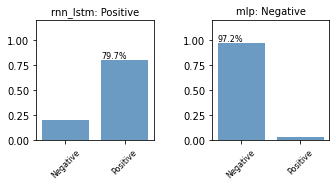

........................................ Negative ........................................
I remember when this came out it was the first kung fu film ever seen around our way and we were all excited about seeing it for sure .Although the action was mediocre at best it gave us our first taste of kung fu and our first taste of bad dubbing as well as bad film making or more precisely the way Chinese people were making films at the time . They were admittedly inferior wlthout question but there was entertainment value here and that caught on for sure . The kung fu craze had begun and Bruce Lee and ''The Chinese Connection'' would soon follow either that or ''The Chinese Boxer'' with Jimmy Wang Yu . In any case this film was chosen to lead the way .


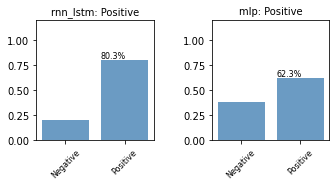

........................................ Negative ........................................
Simply miserable Lana Turner-Ezio Pinza vehicle. Pinza had a beautiful voice but he rarely uses it in a film that reminded me of "The Student Prince" with adults. Pinza is no leading man either. He looks like an elderly man ready to collect social security and go fishing.<br /><br />The plot is extremely thin and the supporting cast of Barry Sullivan, Marjorie Maine and Debbie Reynolds are given so little to do. Sir Cedric Hardwicke comes in at the end to announce that our King Ezio had better return to his people. As far as I'm concerned, the faster the better. Is that Lana Turner really singing with Pinza? Not bad if it is her. The picture would also remind me in a way of the 1960 movie "The Prince and the Showgirl" with Marilyn Monroe and Laurence Olivier.


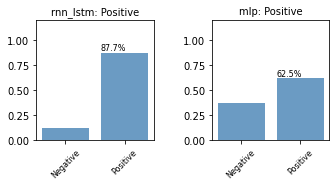

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.122995,0.9585,0.240577,0.9017,5120770,103.0
rnn_lstm,0.090939,0.9754,0.371923,0.8552,4321402,2589.0


In [33]:
helper.model_summary(model, history=history)

#### LSTM + Bidirectional + Stacked

In [34]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm_stacked/checkpoint
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
________________

In [35]:
# history = helper.train(model)

In [36]:
# helper.model_summary(model, history=history)

### Embedding

In [43]:
def get_embedding(helper,
                 embedding_dim=None,
                 dropout=None,
                 name='embedding'
                ):

    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    if embedding_dim is None:
        embedding_dim = helper.get_model_param(name, 'embedding_dim')        
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_features,
                               output_dim=embedding_dim,
                               input_length=input_shape[0],
                               mask_zero=True))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_embedding(helper)
model.summary()

model_params.embedding.dropout=0.2
model_params.embedding.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/embedding/checkpoint
Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 200)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 4,000,602
Trainable params: 4,000,602
Non-trainable params: 0
_________________________________________________________________


2021-01-05 03:18:36,718: INFO: start training


model_params.embedding.epochs=10
use ModelCheckpoint(filepath=./checkpoints/imdb/embedding/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/10
781/781 [==============================] - 27s 35ms/step - loss: 0.4119 - accuracy: 0.8350 - val_loss: 0.2996 - val_accuracy: 0.8771
Epoch 2/10
781/781 [==============================] - 19s 25ms/step - loss: 0.2146 - accuracy: 0.9199 - val_loss: 0.2791 - val_accuracy: 0.8852
Epoch 3/10
781/781 [==============================] - 19s 24ms/step - loss: 0.1551 - accuracy: 0.9472 - val_loss: 0.2942 - val_accuracy: 0.8832
Epoch 4/10
781/781 [==============================] - 21s 27ms/step - loss: 0.1154 - accuracy: 0.9637 - val_loss: 0.3208 - val_accuracy: 0.8770
Epoch 5/10
781/781 [==============================] - 29s 37ms/step - loss: 0.0848 - accuracy: 0.9757 - val_loss: 0.3608 - val_accuracy: 

2021-01-05 03:22:34,201: INFO: finish training [elapsed time: 237.48 seconds]


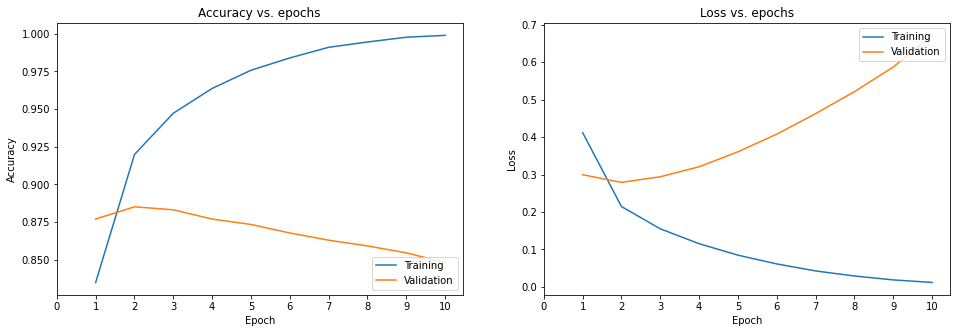

In [44]:
history = helper.train(model, batch_size=32)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 3s 3ms/step - loss: 0.2791 - accuracy: 0.8852
Test loss:0.2791, Test Accuracy:88.52%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 2s 3ms/step


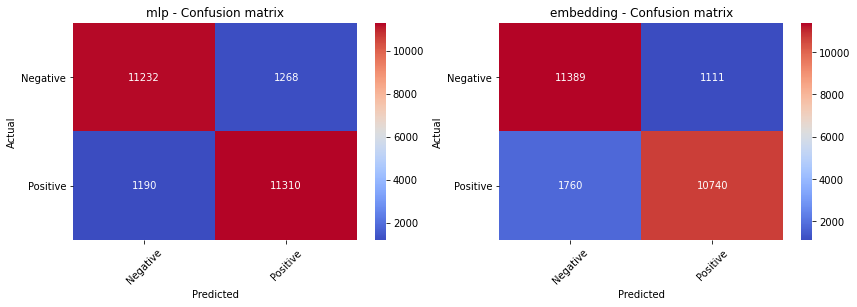

---------------------------------------- error analysis ----------------------------------------
782/782 [==============================] - 2s 3ms/step
........................................ Positive ........................................
The film had NO help at all, promotion-wise: if there was an advertising promo on TV or radio, I didn't see/hear it. The only newspaper ad I saw was on it's opening weekend: a dingy, sludgy B & W head-shot photo of Andy as Val-Com, behind jail bars, with headline: "WANTED! Runaway Robot!" ( which was also the poster in front of the 3 movie theaters I saw it at --NOT the nice little color poster on this site, with headshots of all the cast, and cartoon of Crimebuster --which really wasn't THAT good--they OUGHT to have used an action scene from the film itself--didn't they have an onset photographer? A poster is supposed to HELP a prospective audience decide if they want to SEE the movie--there were SO many people who couldn't get into their sold-ou

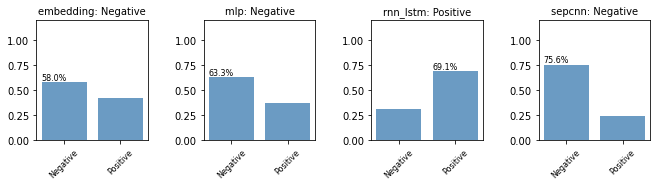

........................................ Positive ........................................
Britain and France declared war on Germany in 1939, but by then, almost all of Europe had fallen under the advance of the Nazi war machine. Entering the war, Britain virtually started from scratch, with scarce supplies and with an air force that was outnumbered by Germany ten to one. But the will of the Brits was firm, emboldened by their new Prime Minister Winston Churchill who declared - "We shall never go under".<br /><br />On August 8, 1940, the Battle for Britain was on. However for the first time since Hitler's declared stance to conquer the world, he hit a wall. Though massively outnumbered, the British Royal Air Force went on the offensive, and in the span of twenty eight days in September and October of 1940, German Luftwaffe casualties climbed to two thousand three hundred seventy five lost planes and crew. Hitler's rage was seething, but he had to call a momentary time out. Responding 

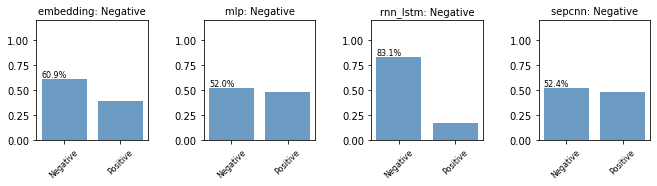

........................................ Positive ........................................
As everyone knows by now, 15 Park Avenue is the story of a schizophrenic girl and her half-sister.<br /><br />The manifestation of Schizophrenia is still viewed as being an illness which people often feel might disappear if ignored. There are also those, who, however far fetched it may seem when it's shown in the film, think that the illness manifests itself as a result of some sort of supernatural influence. I think Ms. Sen deserves a lot of praise for "15 Park Avenue". She has done a good turn, not only to the general public, but also to those who deal with schizophrenics ... relatives, social workers, psycho-analysts. The film actually helps in dispelling a lot of myths and misconceptions about the exact nature of this psychological disorder. I'm told that the film is largely based on her own personal experiences with a person very close to her, who suffers from this mental affliction. To that

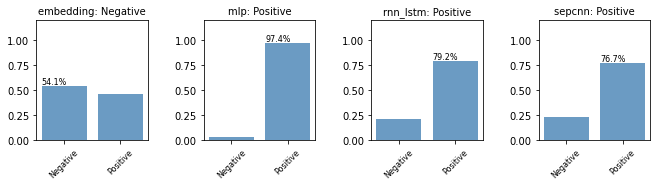

........................................ Positive ........................................
At first I didn't think that the performance by Lauren Ambrose was anything but flaky, but as her character developed the portrayal made more sense. Amy Madigan seemed too terse for her role and didn't really tie her daughter's characters together, even though it was apparent that her character was disengaged with the character played by Lauren Ambrose.<br /><br />Christopher Lloyd is a hit as usual and carried off his role to encourage the story line. His character development left the audience wondering why he was chastised by the younger characters and could have been accomplished more directly with <br /><br />The overwhelming glue to this somewhat vague story line was play by Taylor Roberts. Her comprehensive delivery of a simplistic character held the movie together. In this pivotal role, Taylor was able to encourage a realistic family relationship between the characters while acting as the

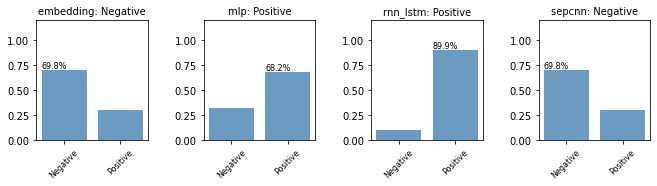

........................................ Positive ........................................
Hey there Army Sgt. I'm sorry dude but being a SGT in the Army and being in the Army National Guard does not make you qualified to comment on a Marine movie. You are not a Marine and just because you wear a uniform doesn't mean you can relate to being a Marine. We simply are the best, we have the hardest training, yes we have big heads about ourselves, but hey when you are the best, you like to strut your stuff. I was in the Iraq invasion and in Fallujah. I fought next to soldiers. You are not "qualified" to say anything about my Marine Corps. I hate to be the one that starts the whole "which branch is better", but you have no right to say you are qualified to judge a Marine movie. Oh yeah......we are Drill Instructors.......not Drill SGT's. That's the biggest clue you have no idea about what you are talking about. Yeah we do not "curse" at recruits anymore. Tell me, how is cussing at someone goi

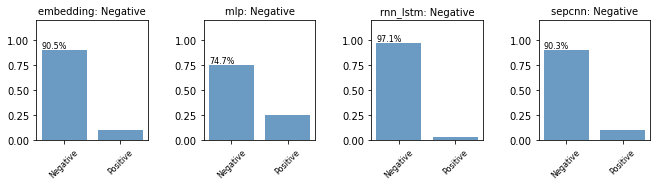

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.122995,0.9585,0.240577,0.9017,5120770,103.0
embedding,0.189284,0.9375,0.283203,0.8890,4000602,186.0
sepcnn,0.150104,0.9525,0.281168,0.8884,4043682,233.0
rnn_lstm,0.090939,0.9754,0.371923,0.8552,4321402,2589.0


In [45]:
helper.model_summary(model, history=history)

### sepCNN

In [46]:
def get_sepcnn(helper,
                 blocks=1,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable,
                                   mask_zero=True))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   mask_zero=True))

    for i in range(blocks):
        model.add(layers.Dropout(rate=dropout))
        if i==blocks-1: filters=filters*2
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(len(params.classes)))
    helper.compile(model)  
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_sepcnn(helper, blocks=1)
# when bolcks=2, the model can't converg
model.summary()

model_params.sepcnn.dropout=0.4
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/sepcnn/checkpoint
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_____________________

2021-01-05 03:22:50,169: INFO: start training


model_params.sepcnn.epochs=10
use ModelCheckpoint(filepath=./checkpoints/imdb/sepcnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/10
781/781 [==============================] - 23s 30ms/step - loss: 0.5660 - accuracy: 0.6473 - val_loss: 0.3025 - val_accuracy: 0.8826
Epoch 2/10
781/781 [==============================] - 23s 30ms/step - loss: 0.2535 - accuracy: 0.9026 - val_loss: 0.2761 - val_accuracy: 0.8900
Epoch 3/10
781/781 [==============================] - 23s 29ms/step - loss: 0.1708 - accuracy: 0.9371 - val_loss: 0.2999 - val_accuracy: 0.8854
Epoch 4/10
781/781 [==============================] - 23s 30ms/step - loss: 0.1109 - accuracy: 0.9605 - val_loss: 0.3488 - val_accuracy: 0.8795
Epoch 5/10
781/781 [==============================] - 23s 29ms/step - loss: 0.0764 - accuracy: 0.9730 - val_loss: 0.4347 - val_accuracy: 0.8736

2021-01-05 03:26:42,765: INFO: finish training [elapsed time: 232.60 seconds]


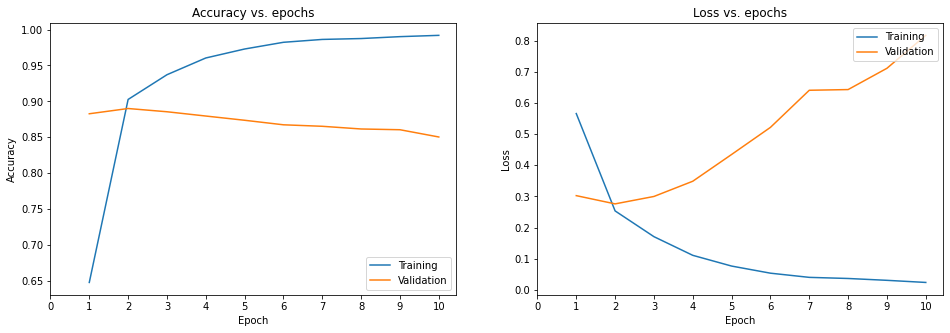

In [47]:
history = helper.train(model, batch_size=32)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 4s 5ms/step - loss: 0.2761 - accuracy: 0.8900
Test loss:0.2761, Test Accuracy:89.00%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 3s 4ms/step


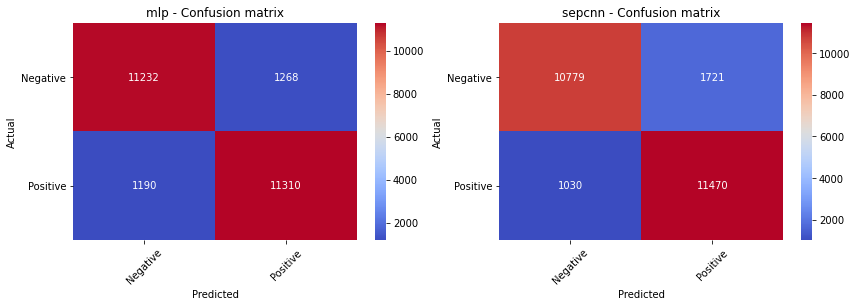

---------------------------------------- error analysis ----------------------------------------
782/782 [==============================] - 3s 4ms/step
........................................ Positive ........................................
To my eternal shame, I've never seen a silent movie - not even the mother of all vampire movies, "Nosferatu". However, if they display half the creativity and sheer joy of this effort from Buster Keaton then I'll probably try to watch a few more. This is genuinely funny as well as being a stunning introduction to the world of the silent comedies. The premise, such as it is, focuses around an unfortunate case of mistaken identity as Keaton is mistaken for renowned bad-guy Dead Shot Dan (co-director Malcolm St Clair). This leads to a number of chases and escapes as the authorities get ever closer to the increasingly desperate Keaton.<br /><br />You're left amazed and entertained in equal measures. Keaton is a natural comedian but also an accomplishe

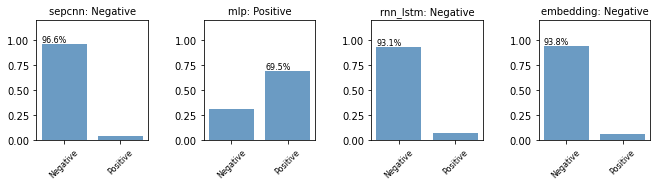

........................................ Positive ........................................
I have a letter from Ms. Knight, who went to college with my older sister. In it, she tells of the hardships of making this film. She, herself, was pregnant--an interesting conjunction with the movie's plot--and the novice director was unsure, fairly green, and having great difficulties with all the decisions, logistics, etc. They were on the move all the time, and it was a very difficult shoot. <br /><br />The film, however, with a strong debut for James Caan, remains effective and affecting. It's a great showcase for the talent that Ms. Knight has demonstrated her entire career--on television, in movies and on the stage, where she won the Tony for "Kennedy's Children."<br /><br />This film has aged well.


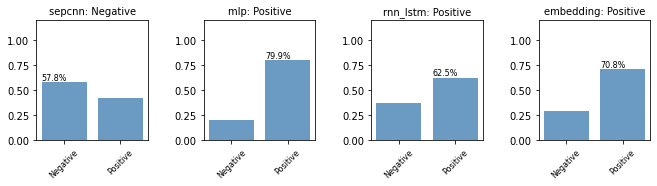

........................................ Positive ........................................
Well, I'm not about to add to the diatribe that's been 'preached' about this film.<br /><br />All I can add is that at NO time does it even pretend to be a 'historic' picture. Unlike 'Braveheart', 'Titanic' or 'The Patriot' all of which have very credible and serious historical amendments, purely for theatric effect (possible the worst of excuses). <br /><br />Has everyone taken a sense of humor bypass? <br /><br />All I can add is a paraphrase from the good Captain Macleane - 'It looked<br /><br />fantastic and we have a bloody good laugh'.<br /><br />- One last point. What astonishes me is that there are comments relating to the 'modern music' in a historic setting. I wonder if the same people made the same judgment about Moulin Rouge. I suggest not.


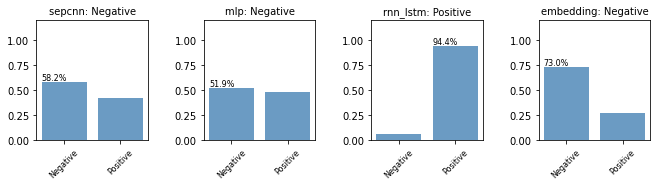

........................................ Negative ........................................
Surrender Cinema has been known for their extremely erotic, almost explicit sci-fi films. While they generally do very well at these (Femalien 1 & 2, Virtual Encounters), this particular entry seems to be just a rehash of old tape. Any number of girls -- some recognizable and others not -- are in this film in all stages of nudity. There are also several clips from other films which are outstanding, unless you've seen those other films. There are a number of solo nude scenes doing a number of things -- some playing basketball, others talking, still others playing with themselves. The only thing of value in this tape is the very last scene -- a short but erotic girl-girl scene with a very enthusiastic and enjoyable Sandy Wasko and a more subdued Tammie Hainum. Not highly recommended.


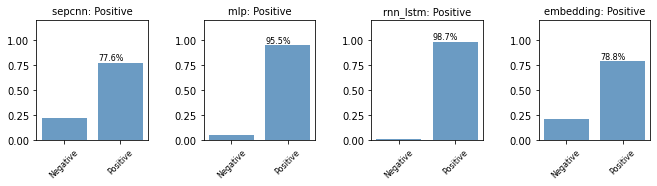

........................................ Negative ........................................
"Wild Rebels" was probably a fun second film at a drive in movie triple feature 40 years ago. It hasn't aged very well, but it was never meant to age well; it was obviously intended to be disposable, forgettable fun from its inception. Taken on that level, it's a good example of the biker flick genre.<br /><br />Several elements help distinguish it from the dozens of similar films being churned out at the same time. The 'hero', 'Rod Tillman' (Steve Alaimo) comes off as somewhat of an unimpressive 'Everyman' - he's not especially brave, tough, talented, or handsome (although he does win a fight with a tough biker gang member halfway into the film, and the girl gang member chooses to help him over her fellow gang member at the end of the film). The soundtrack is quite well done, featuring a nice 'Ventures' style bass/drum riff that keeps things moving and saxophones and brass charts that pep things

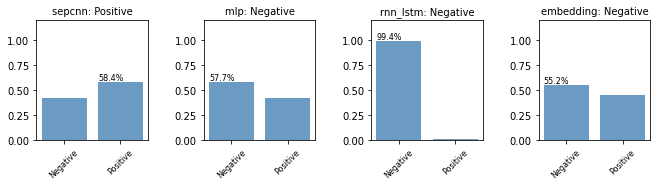

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.122995,0.9585,0.240577,0.9017,5120770,103.0
sepcnn,0.152246,0.9488,0.276065,0.8900,4043682,232.0
embedding,0.189284,0.9375,0.283203,0.8890,4000602,186.0
rnn_lstm,0.090939,0.9754,0.371923,0.8552,4321402,2589.0


In [48]:
helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)